# Detecting Climate Change Disinformation on Twitter
Andres De La Fuente

University of Washington, 2021


## Introduction

The idea of this project is to explore a collection of tweets which are about a political topic (Climate Change), and employ specific features related to user accounts in order to potentially identify evidence of astroturfing. In this project I focus on identifying the presence of bots, and analyzing whether these suspicious accounts display differences in the content of their posts (relative to the overall trends) which would suggest a particular agenda.

## Motivation
The way we consume information has changed dramatically in the past decade or so. People are exposed to more information than ever before, and it has become completely unfeasible for a given individual to identify the trustowrthiness of the content they are seeing. It has become clear that various forms of manipulative tactics on social media are very effective, as they have been used to influence elections, and more recently to sow distrust in the medical community (Coronavirus disinformation). 

It would be incredibly useful for us to start investigating these dynamics and treating the flow of information on the internet as the essential basis of society that it has become. Ideally, this project would successfully find evidence of politically motivated astroturfing by bot accounts with relation to the subject of climate change.

## Data
For this analysis, I use the following dataset of tweets about climate change:

[Data](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/5QCCUU)

The data simply contains the IDs of tweets which feature climate change related hashtags such as #climatechange or #climatehoax.

The license for the dataset is CC0, and is for public use. The terms of service require citation. 
This data fulfills my purposes because it provides a set of tweets already grouped by focus on a specific political topic.

The primary reason for using tweets related to climate change is that I want to focus on a political topic for which what we consider to be disinformation is widely agreed upon. There is such a broad scientific consensus on the reality of man made climate change that I can go into the analysis with the assumption that climate denial is a form of disinformation.

A broad ethical consideration with relation to this type of analysis is the implication of using human generated content to identify intent. It is possible to mischaracterize real user behavior as disingenous organized behavior, and if this is the case the insights might falsely suggest that a particular agenda is purely pushed by artificial activity. That said, the feature of posting frequency I use in this analysis is a very strong indication of bots, and I have confidence that the accounts identified as potential bots, thanks to this feature, are indeed not human users.

### How to Set Up the Data Yourself
The referenced dataset contains identifier numbers for the selected tweets. It numbers in the millions of tweets, but I use a subset of that here. The dataset is broken into three separate text files in on the source website, download the first of these files.

Next, you need a tool such as [Twarc](https://github.com/DocNow/twarc), which is what I use, to 'hydrate' the tweets. This means that you are going through Twitter's developer API to reference the tweet identifiers and retrieve all of the information for each tweet. This is returned in JSON format. 

**You need a Twitter Developer account to perform the hydration process**. 

Unfortunately, Twitter's Terms of Service do not allow the public sharing of full tweet information colleted through their API, so I can only share tweet identifiers (this is the reason my referenced dataset is also in this format).

For my analysis, I use a randomly selected subset of 100,000 tweets. To select these tweets I use the following command in a Linux terminal:

```
shuf -n 100000 input_file.txt > output_file.txt
```

Once you have done this, perform the hydration using Twarc on your output_file.txt (however you wish to name it). The resulting JSON file is what you should use as input in 'Loading Data' section below. In my code, this is called "small_tweets.jsonl". I have included my particular sample of 100000 tweet IDs as "small_sample.txt" in the repository.


# Research Questions
**Are there features about user accounts which are indicative of inorganic activity and which can effectively distinguish the accounts in this dataset?**

**Given groupings based on these features, are there meaningful differences in tweet content? Do tweets in the suspect user group feature more of a certain hashtag or use of URLs?**

**Do these differences suggest a particular agenda for the suspected accounts?**

# Background / Related Work
[Political Astroturfing in South Korea](https://www.researchgate.net/profile/Junghwan_Yang2/publication/317290047_How_to_Manipulate_Social_Media_Analyzing_Political_Astroturfing_Using_Ground_Truth_Data_from_South_Korea/links/59305a9ca6fdcc89e7844440/How-to-Manipulate-Social-Media-Analyzing-Political-Astroturfing-Using-Ground-Truth-Data-from-South-Korea.pdf)

[Russian Political Disinformation](https://secondaryinfektion.org/)

[Detecting the Use of Multiple Accounts](https://onlinelibrary.wiley.com/doi/abs/10.1002/cpe.4013)

[Common Signs of Bots](https://blog.mozilla.org/internetcitizen/2018/01/08/irl-how-to-spot-a-bot/)

The somewhat limited work that exists in this area indicates two different kinds of analyses that are used to identify inorganic activity. First, there is the consideration of individual user features, such as an account's age and posting frequency, which can be useful for identifying bots. Second, when looking for astroturfing, it is necessary to consider trends and patterns in posting activity, finding similarities in content even across platforms. The latter type of analysis is much more involved and technically complicated, so I will focus on the former: user account features.

# Methodology

**Exploratory Visualizations:** 

I use some exploratory visualizations and statistical summaries to explore the user features which I have identified as potential indicators of inorganic activity.

**Clustering Algorithms:** 

Since some of these features turn out to indicate strong distinctions among user accounts, and the suspicious accounts number far fewer than the overall accounts, I use Gaussian Mixture clustering to group accounts based on these features.

**Manual Subset Selection:**

Besides clustering, due to the very interpretable nature of the selected features, I also manually select a subset of accounts by using cutoffs for these features.

**NLP** 

I use simple NLP to calculate things such as the presence of hashtags in the different tweet groupings, as well as the use of URLs. Pretrained sentiment analysis is used for a very rudimentary look at sentiment in the body of these tweets.



In [122]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

## Helper Functions
Below are helper functions that are used further down through the analyses.

&nbsp;

**percentNumbers**

This calculates the percentage of numerical digits in a string, to be used on screen names of twitter accounts.

In [131]:
def percentNumbers(my_string):
    return (len(re.sub("[^0-9]", "", my_string))/len(my_string))

**listNotEmpty**

This returns True if the given list is empty, to be used for noting the presence of things within a tweet of which there could be more than one (e.g. URLs).

In [61]:
def listNotEmpty(my_list):
    return(len(my_list) > 0)

In [67]:
def containsOrg(url_list):
    contains = False
    for i in url_list:
        if (".org" in i):
            contains = True
    return contains

## Load and Preview Data
First, I load the data from the json file generated by hydrating the list of tweet ID's through Twitter's API. 

I preview the data in the following cell.

In [79]:
dfs = pd.read_json('small_tweets.jsonl', encoding='utf-8', lines=True)

In [89]:
dfs.head()

,created_at,id,id_str,full_text,truncated,display_text_range,entities,source,in_reply_to_status_id,in_reply_to_status_id_str,...,quoted_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,retweeted_status,extended_entities,withheld_in_countries
0,2018-06-13 21:12:26+00:00,1007007810725597184,1007007810725597184,So concerned for our earth while others just w...,False,"[0, 160]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,...,{'created_at': 'Wed Jun 13 19:07:30 +0000 2018...,0,0,False,False,0.0,en,NaN,NaN,NaN
1,2018-06-16 22:12:00+00:00,1008109966232875009,1008109966232875008,"""Poor people just get the short end of the sti...",False,"[0, 223]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://about.twitter.com/products/tw...",NaN,NaN,...,NaN,1,3,False,False,0.0,en,NaN,NaN,NaN
2,2018-06-21 14:12:17+00:00,1009801182317932544,1009801182317932544,"Even during all of this chaos, these assholes ...",False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://tapbots.com/tweetbot"" rel=""nof...",NaN,NaN,...,{'created_at': 'Thu Jun 21 13:55:07 +0000 2018...,0,1,False,False,0.0,en,NaN,NaN,NaN
3,2018-06-22 01:49:22+00:00,1009976609154088961,1009976609154088960,RT @MikeHudema: These Indigenous defenders are...,False,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com"" rel=""nofollow"">Tw...",NaN,NaN,...,NaN,235,0,False,False,0.0,en,{'created_at': 'Thu Jun 21 20:44:01 +0000 2018...,NaN,NaN
4,2018-06-22 15:17:38+00:00,1010180016418590720,1010180016418590720,RT @eugenegu: Trump’s Red Wave is another term...,False,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/android"" ...",NaN,NaN,...,NaN,4023,0,False,False,NaN,en,{'created_at': 'Fri Jun 22 12:09:41 +0000 2018...,NaN,NaN


## Account Feature Exploration
In the following section, I calculate and explore various features related to user accounts which can be indicative of inorganic activity. The selection of these features to focus on is based on the works referenced in the 'Background' section above. The features I look into are:
- Account Age (at the time of posting the tweet)
- Bio Length
- Posting Frequency (posts made per day)
- Percentage of Numbers in Name (screen name, or 'handle')

### Account Age Calculations
One of the most common identifying features of inorganic activity is relatively young accounts. When batches of accounts are made for bot use or human astroturfing, the accounts are typically used right away, rather than letting them age for years before use. As can be observed below, most user accounts are years old.

&nbsp;

**Isolate account creation dates**

First I get a list of the timestamps for account creation related to each tweet.

In [80]:
acct_start = []

for i in dfs['user']:
    acct_start.append(i['created_at'])   

**Calculate age of account when posting each tweet**

Now, I record the difference between the tweet's creation time and associated account's creation time for each tweet.

In [96]:
age_at_post = []

for i in range(len(acct_start)-1):
    # Get the account creation date and post date
    a = acct_start[i]
    b = dfs['created_at'][i]
    
    # Convert both into the same Timestamp format
    a = pd.Timestamp(a).tz_localize(None)
    b = pd.Timestamp(b).tz_localize(None)
    
    # Calculate the age at posting in seconds
    age_at_post.append((b - a).total_seconds())
    

**Convert to days**

I convert the account age at time of posting from seconds to days.

In [112]:
seconds_in_day = 60 * 60 * 24
age_at_post_days = [x / seconds_in_day for x in age_at_post]

### Visualizing Account Ages
Below I visualize the spread of account ages at time of posting. I also display some summary statistics in the following cell. As expected, the distribution implies that the accounts have been created throughout the existence of Twitter, with the average age being a few years.

Text(0, 0.5, 'Accounts')

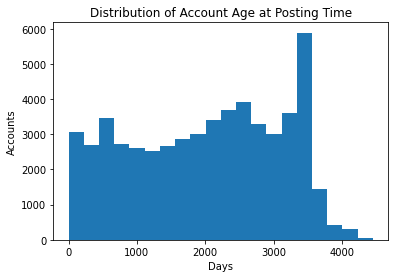

In [113]:
plt.hist(age_at_post_days, bins=20)
plt.title("Distribution of Account Age at Posting Time")
plt.xlabel("Days")
plt.ylabel("Accounts")

In [123]:
stats.describe(age_at_post_days)

DescribeResult(nobs=54605, minmax=(0.001388888888888889, 4451.296400462963), mean=2006.8847893827983, variance=1220624.772413283, skewness=-0.1637655726256907, kurtosis=-1.1726399534435956)

In [124]:
dfs["user"][0]

{'id': 1674050738,
 'id_str': '1674050738',
 'name': 'Catherine Maron',
 'screen_name': 'CCmmaron',
 'location': '',
 'description': 'Proud mom of 3, grateful daughter and partner, teacher and life-long learner.',
 'url': None,
 'entities': {'description': {'urls': []}},
 'protected': False,
 'followers_count': 20,
 'friends_count': 143,
 'listed_count': 0,
 'created_at': 'Thu Aug 15 20:56:49 +0000 2013',
 'favourites_count': 74,
 'utc_offset': None,
 'time_zone': None,
 'geo_enabled': False,
 'verified': False,
 'statuses_count': 67,
 'lang': None,
 'contributors_enabled': False,
 'is_translator': False,
 'is_translation_enabled': False,
 'profile_background_color': 'C0DEED',
 'profile_background_image_url': 'http://abs.twimg.com/images/themes/theme1/bg.png',
 'profile_background_image_url_https': 'https://abs.twimg.com/images/themes/theme1/bg.png',
 'profile_background_tile': False,
 'profile_image_url': 'http://pbs.twimg.com/profile_images/946702944812064769/G9nrKQbU_normal.jpg',
 '

### Posting Frequency Calculations
Another suspicious account feature which is intuitively a good indicator of inorganic activity is an account's posting frequency. Fake accounts, especially bots, are made with the goal of spreading or magnifying some message, therefore they are used to perform large amounts of activity (such as retweeting, which counts as a tweet) relative to the average human user.

&nbsp;

**Calculate number of posts**

First I calculate the number of posts made by the account associated with each tweet.

In [165]:
num_posts = []
for i in range(len(dfs)-1):
    num = dfs['user'][i]['statuses_count']
    num_posts.append(num)

As evidenced by some summary statistics, there are posting amounts which are suspiciously high.

In [167]:
stats.describe(num_posts)

DescribeResult(nobs=54605, minmax=(1, 3655420), mean=74750.6033696548, variance=21746512101.03633, skewness=7.080231064039844, kurtosis=98.9256399619534)

**Caluclate frequency**

Next I calculate the frequency of posts (ratio of total posts versus account age) for the account associated with each tweet.

In [160]:
post_freq = []

for i in range(len(dfs)-1):
    num_posts = dfs['user'][i]['statuses_count']
    age = age_at_post_days[i]
    frequency = num_posts / age
    post_freq.append(frequency)

### Visualizing Posting Frequencies
Below I visualize the spread of posting frequencies associated with each tweet's account. I also display some summary statistics in the following cell. 

The resulting distribution indicates some very extreme outliers. Posting frequencies of tens of thousands of tweets per day are a huge red flag, as it is totally unfeasible for a human to perform. The vast majority of posting frequencies fall below the mean of 91 (which is heavily skewed by the outliers).

Text(0, 0.5, 'Accounts')

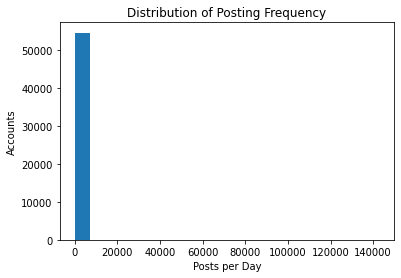

In [163]:
plt.hist(post_freq, bins=20)
plt.title("Distribution of Posting Frequency")
plt.xlabel("Posts per Day")
plt.ylabel("Accounts")

In [174]:
stats.describe(post_freq)

DescribeResult(nobs=54605, minmax=(0.000580973055767449, 142815.7090579847), mean=91.98719210224164, variance=1558431.6618614001, skewness=71.40183435135245, kurtosis=6228.855252451364)

### Bio Length Calculations
Though less strongly indicative of artificial activity, two features related to the user account information might be indicative of fake accounts. Below I look into the length of bio, or 'description, for the account associated with each tweet.

&nbsp;

**Calculate bio length**

I calculate the length of the 'description' string for the account associated with each tweet.

In [127]:
bio_len = []
for i in range(len(dfs)-1):
    length = len(dfs['user'][i]['description'])
    bio_len.append(length)

### Visualizing Bio Lengths
Here I visualize the spread of bio lengths (in characters).  I also display some summary statistics in the following cell.

The distribution appears bimodal, with large numbers of accounts at each end of the length spectrum. As evidenced further down, when I take a look at some sample accounts, the bio length is not as useful of a feature for identifying 'fake' accounts.

Text(0, 0.5, 'Accounts')

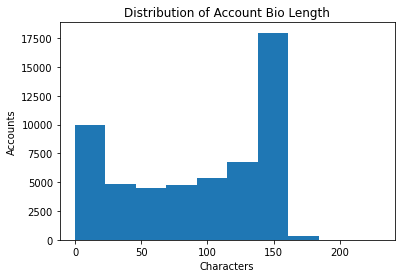

In [130]:
plt.hist(bio_len)
plt.title("Distribution of Account Bio Length")
plt.xlabel("Characters")
plt.ylabel("Accounts")

In [175]:
stats.describe(bio_len)

DescribeResult(nobs=54605, minmax=(0, 230), mean=92.64827396758538, variance=3259.9901243465947, skewness=-0.37550876747077083, kurtosis=-1.3379301594578963)

### Percent of Numbers in Name Calculations
As a final user account feature to explore, I look at the percentage of numerical digits in an account's screen name, or 'handle'. According to [this Mozilla resource](https://blog.mozilla.org/internetcitizen/2018/01/08/irl-how-to-spot-a-bot/) referenced in the 'Background' section above, account names with a jumble of letters and numbers can be indicative of bots. This makes sense, as creating batches of accounts in some automated fashion would be easier if generating such names.

&nbsp;

**Calculate percentage**

I calculate the percentage of numerical digits (0 through 9) present in the account screen name associated with each tweet. I use a helper function defined above to do this.

In [132]:
num_in_name = []

for i in range(len(dfs)-1):
    percent_num = percentNumbers(dfs['user'][i]['screen_name'])
    num_in_name.append(percent_num)

### Visualizing Percent of Numbers in Names
Below I visualize the spread of percentages of numerical digits in accounts' screen names. I also display some summary statistics in the following cell.

Like posting frequency, this is a very skewed distribution. The bulk of accounts have less than 10% numbers in their screen names, yet some accounts go up to more than 50% of their names being numbers.

Text(0, 0.5, 'Accounts')

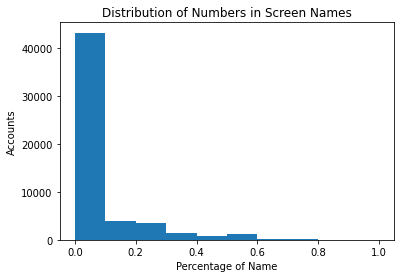

In [133]:
plt.hist(num_in_name)
plt.title("Distribution of Numbers in Screen Names")
plt.xlabel("Percentage of Name")
plt.ylabel("Accounts")

In [176]:
stats.describe(num_in_name)

DescribeResult(nobs=54605, minmax=(0.0, 1.0), mean=0.06159344379333392, variance=0.017366342398283604, skewness=2.52650107976554, kurtosis=6.561198588477829)

### Visualizing Tweets Based on Suspect Account Features
Below I plot the tweets according to the 3 of the potentially identifying features for inorganic activity:
- Account Age at Time of Posting
- Percent of Numbers in Name
- Posting Frequency

As can be observed, there are several accounts which are clear stand outs. An interesting observation is that the **bio length** is not really as useful of a differentiator as **posting frequency** and **account age**. **Posting frequency** appears to be the greatest distinguishing factor, and the highest posting frequencies are all for *very* young accounts. This is what would be expected for bot accounts. No human user would reasonably post tens of thousands of tweets within a day of making an account.

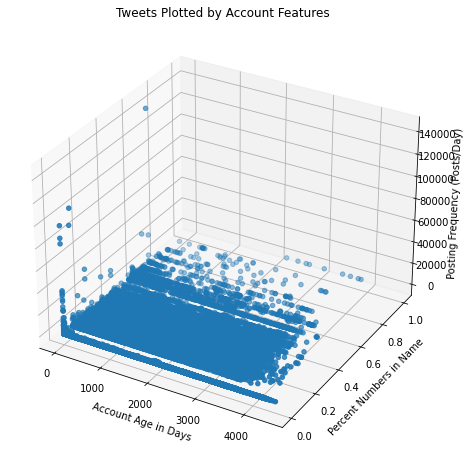

In [178]:
fig = plt.figure(figsize=(6, 6))
ax = Axes3D(fig)
ax.set_title("Tweets Plotted by Account Features")
ax.set_xlabel("Account Age in Days")
ax.set_ylabel("Percent Numbers in Name")
ax.set_zlabel("Posting Frequency (Posts/Day)")
ax.scatter(age_at_post_days, num_in_name, post_freq)

In [139]:
dfs["postAge"] = 0
for i in range(len(dfs) - 1):
    postTime = pd.Timestamp(dfs["created_at"][i]).tz_localize(None)
    acctTime = pd.Timestamp(dfs["user"][i]["created_at"]).tz_localize(None)
    postAge = (postTime - accountTime).asm8.astype(int) / 3600000000000
    dfs["postAge"][i] = postAge

/home/oponn/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [162]:
cluster_features = dfs[["postAge", "followCount", "bioLength"]]

In [163]:
cluster_features.head()

,postAge,followCount,bioLength
0,42312,20,77
1,42385,79910,59
2,42497,277,51
3,42508,1599,86
4,42522,363,93


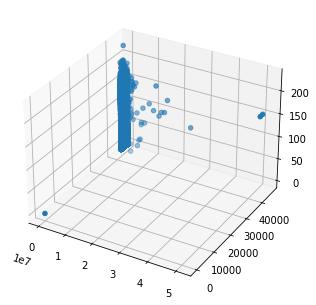

In [173]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(cluster_features['followCount'], cluster_features['postAge'], cluster_features['bioLength'])

In [176]:
dfs_clip = cluster_features

In [181]:
dfs_clip['followCount'] = dfs_clip['followCount'].where(dfs_clip['followCount'] <= 1000000, 1000000)

/home/oponn/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [183]:
dfs_clip['postAge'] = dfs_clip['postAge'].where(dfs_clip['postAge'] >= 40000, 40000)

/home/oponn/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


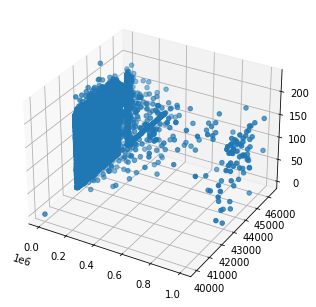

In [184]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(cluster_features['followCount'], cluster_features['postAge'], cluster_features['bioLength'])

In [194]:
kmeans = KMeans(n_clusters=4).fit(dfs_clip)

In [191]:
kmeans.predict(dfs_clip)

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

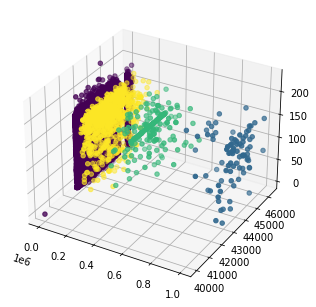

In [195]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(cluster_features['followCount'], cluster_features['postAge'], cluster_features['bioLength'], 
            c=kmeans.predict(dfs_clip))

In [201]:
hashtaglist = []
for i in range(len(dfs)-1):
    for l in dfs['entities'][i]['hashtags']:
        hashtaglist.insert(0, l)
hashtaglist

[{'text': 'climatechange', 'indices': [60, 74]},
 {'text': 'GlobalWarming', 'indices': [29, 43]},
 {'text': 'union', 'indices': [101, 107]},
 {'text': 'ClimateJustice', 'indices': [80, 95]},
 {'text': 'CoalEmissions', 'indices': [239, 253]},
 {'text': 'climatechange', 'indices': [124, 138]},
 {'text': 'NASA', 'indices': [103, 108]},
 {'text': 'California', 'indices': [79, 90]},
 {'text': 'WarOnOurFuture', 'indices': [118, 133]},
 {'text': 'QandA', 'indices': [74, 80]},
 {'text': 'climatechange', 'indices': [85, 99]},
 {'text': 'climatechangeisreal', 'indices': [115, 135]},
 {'text': 'HealtheWorld', 'indices': [186, 199]},
 {'text': 'OurFuture', 'indices': [175, 185]},
 {'text': 'Conservation', 'indices': [161, 174]},
 {'text': 'Carnivores', 'indices': [149, 160]},
 {'text': 'Activism', 'indices': [139, 148]},
 {'text': 'Animals', 'indices': [130, 138]},
 {'text': 'Agenda', 'indices': [122, 129]},
 {'text': 'Vegan', 'indices': [115, 121]},
 {'text': 'HeatingUp', 'indices': [104, 114]},


In [215]:
dfs['entities'][60]['hashtags']['text']

TypeError: list indices must be integers or slices, not str

In [263]:
df_bad = dfs[dfs['bioLength'] < 5]
df_bad = df_bad[df_bad['followCount'] < 1000]

In [264]:
hashtaglist = []
for i in df_bad['full_text']:
    for word in i.split():
        if word[0] == '#':
            hashtaglist.append(word[1:])
        
print(hashtaglist)

['newspapers', 'feedly', 'ActOnClimate', 'ClimateAction', 'globalwarming', 'carbo…', 'globalwarming', 'climatechange', 'globalwarming…', 'Plant4Pakistan', 'GreenP…', 'PalmOil', 'DadesRemotes', 'ClimateAction', 'GlobalWarming', 'climatechange', 'DefendTheAmazon!', 'ClimateJustice', 'ActOnClimate', 'ThingsYouDontSeeEveryDay', 'Weather', 'Greenland', 'Clim…', 'ZEVsummit:', 'climatechange.', 'climatechange', 'fossilfuel.', '…', 'environmental', 'climatechange', 'Cape', 'climatechange,', 'Quito', 'ClimateChang…', 'greenparty', 'climate', 'ClimateChange', 'ClimateAc…', 'haecext', 'climatechange', 'NationalWomensEnterpriseDay', 'climatechange', 'agenda2030', 'zerohunger', 'ClimateChange.', 'LDTPoll:', 'environmental', 'ClimateChange', 'Renewables', 'Sustainability', 'Norway,', 'Finland', 'Iceland', 'PlasticMenace', 'SayNoTo…', 'FlorenceNC', 'florencehurrica…', 'Neoliberalism', 'Growt…', 'GiveAFlake', 'ClimateChange', 'BanFossilFuels', 'HeathrowExpansion', 'NoThirdRunway', 'ParisAgreement', 'V

In [239]:
from collections import Counter

In [265]:
counts = Counter(hashtaglist)

In [266]:
counts.most_common(5)

[('climatechange', 156),
 ('ClimateChange', 103),
 ('climate', 26),
 ('climatechan…', 25),
 ('Plant4Pakistan', 24)]

In [244]:
190 / len(df_bad)

0.027436823104693142

In [248]:
df_bad.columns

Index(['created_at', 'id', 'id_str', 'full_text', 'truncated',
       'display_text_range', 'entities', 'source', 'in_reply_to_status_id',
       'in_reply_to_status_id_str', 'in_reply_to_user_id',
       'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo',
       'coordinates', 'place', 'contributors', 'is_quote_status',
       'quoted_status_id', 'quoted_status_id_str', 'quoted_status_permalink',
       'quoted_status', 'retweet_count', 'favorite_count', 'favorited',
       'retweeted', 'possibly_sensitive', 'lang', 'retweeted_status',
       'extended_entities', 'withheld_in_countries', 'postAge',
       'percentNumInName', 'bioLength', 'followCount'],
      dtype='object')

<BarContainer object of 5 artists>

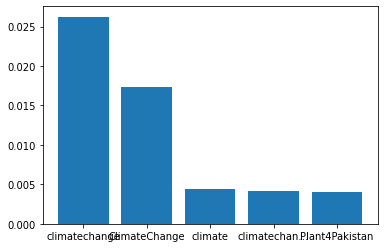

In [289]:
plt.bar([i[0] for i in counts.most_common(5)], [i[1] / len(df_bad) for i in counts.most_common(5)])


In [291]:
df_bad.columns

Index(['created_at', 'id', 'id_str', 'full_text', 'truncated',
       'display_text_range', 'entities', 'source', 'in_reply_to_status_id',
       'in_reply_to_status_id_str', 'in_reply_to_user_id',
       'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo',
       'coordinates', 'place', 'contributors', 'is_quote_status',
       'quoted_status_id', 'quoted_status_id_str', 'quoted_status_permalink',
       'quoted_status', 'retweet_count', 'favorite_count', 'favorited',
       'retweeted', 'possibly_sensitive', 'lang', 'retweeted_status',
       'extended_entities', 'withheld_in_countries', 'postAge',
       'percentNumInName', 'bioLength', 'followCount'],
      dtype='object')

In [308]:
df_bad["entities"][19]['urls'][0]['url']

'https://t.co/unyyK8XwDl'

In [315]:
df_bad["HasURL"] = False
for i in df_bad["entities"]:
    df_bad["HasURL"] = listNotEmpty(i["urls"])

IndexError: list index out of range

<AxesSubplot:>

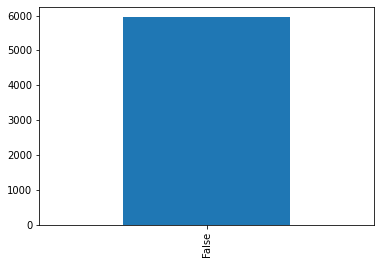

In [314]:
df_bad["HasURL"].value_counts().plot(kind='bar')